# Introduction
Kaggle provides a dataset of tweets with labels to try and identify which tweets indicate a real disaster. Given the nature of social media, a user can tweet about anything. Sometimes these tweets will be harmless observations or commentary, and other times these tweets will contain valuable information about dangerous events. Can we develop a machine learning model to classify which tweets contain this possibly life saving information?  

In this notebook I will perform some data exploration and any necessary cleaning; then use the Keras library to fit and tune a couple different types of Recurrent Neural Networks to see how well I can classify these tweets.  

To enable the use of GPUs, I will run this notebook in Google Colab with an NVIDIA L4 GPU enabled.

In [53]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

kagglehub.login()


In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

nlp_getting_started_path = kagglehub.competition_download('nlp-getting-started')

print('Data source import complete.')


100%|██████████| 593k/593k [00:00<00:00, 713kB/s]

Extracting files...
Data source import complete.


## The Data
Kaggle provides training and testing datasets. The traing dataset contains four columns id (integer), keyword (string), location (string), text (string), and target (string) with 7,613 rows. The testing set contains all of the same columns except for target, with 3623 rows.
  
The id identifies the record. Keyword seems to be a one or two words summary of the tweet, I'm not sure how that gets derived. Location is the location of the user at the time of the tweet. Text is the actual text of the tweet, this is our most important field. And target is the class we're trying to predict.

In [41]:
# load the data
data_path = '/root/.cache/kagglehub/competitions/nlp-getting-started'
print(os.listdir(data_path))

train_im = pd.read_csv(data_path + '/train.csv')
test_im = pd.read_csv(data_path + '/test.csv')


['test.csv', 'sample_submission.csv', 'train.csv']


In [42]:
# make copies to work with
train = train_im.copy()
test = test_im.copy()

print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None


## Exploratory Data Analysis
We start by reviewing a few rows of the data. From there we count how many missing rows show up in each field.

### Let's look at a sample of tweets in the training set. It appears that keyword and location might not show up that often.

In [7]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
# show keyword gouups
print(train.groupby('keyword')['id'].count())
print()
# count NaN keywords
print(f'Rows missing keyword: {train.keyword.isna().sum()}')
print()
print(f'Rows missing location: {train.location.isna().sum()}')

keyword
ablaze                 36
accident               35
aftershock             34
airplane%20accident    35
ambulance              38
                       ..
wounded                37
wounds                 33
wreck                  37
wreckage               39
wrecked                39
Name: id, Length: 221, dtype: int64

Rows missing keyword: 61

Rows missing location: 2533


### There weren't as many missing keywords as I initial thought. However, about a third of the dataset is missing location. Because I don't know how the dataset generates the keyword, I won't be using that in my analysis. Also, because so many tweets are missing location, I won't use that field either.
  


### Let's look at the distribution of text length for the tweets by class.

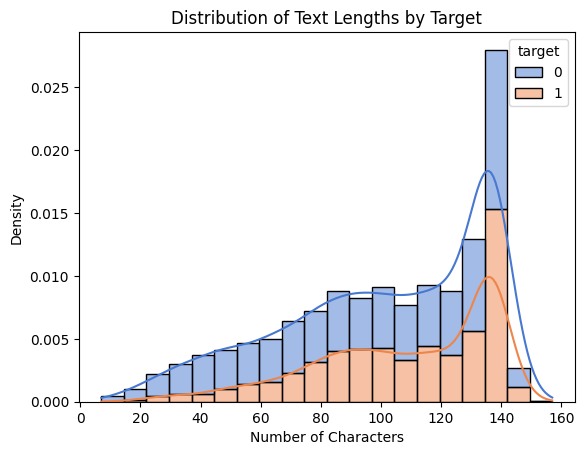

In [5]:
# add length column
train['text_len'] = train['text'].str.len()

# plot a histogram of the length colored by target
sns.histplot(
    data = train
    , x = 'text_len'
    , hue = 'target'
    , multiple = 'stack'
    , bins = 20
    , stat = 'density'
    , kde = True
    , palette = 'muted'
  )
plt.title("Distribution of Text Lengths by Target")
plt.xlabel("Number of Characters")
plt.ylabel("Density")
plt.show()

### I'm suprised by how similar these distributions are. It seems like tweet length won't help in our classification.
  
### Another important consideration is the distribution of our target class. Let's look at a bar chart of how many we have of each target.

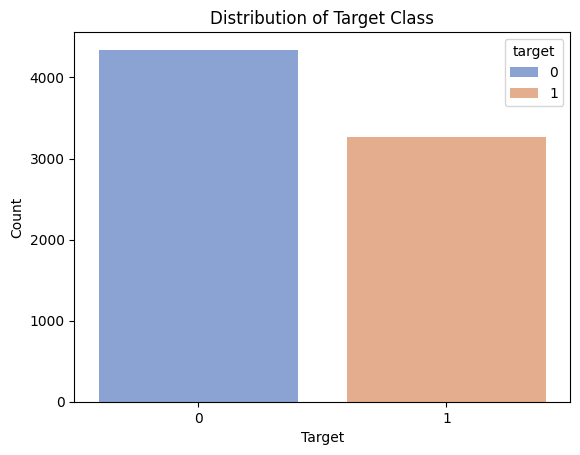

In [6]:
# bar chart of target
sns.countplot(
    data = train
    , x = 'target'
    , hue = 'target'
    , palette = 'muted'
    , alpha = 0.7
  )
plt.title("Distribution of Target Class")
plt.xlabel("Target")
plt.ylabel("Count")
plt.show()

### There's a slight imbalance here but nothing I would adjust our approach over.

### Based on the results of the EDA I will move forward with modeling this data using a Recurrent Neural Network approach. These neural networks perform best when used with sequential data, and that's exactly what text is; each word get's more meaning when taken in context with the words before and after it.

## Cleaning
Because we're going to use RNN, we need to turn our words into numbers. To accomplish, this I will tokenize and vectorize the text column. Tokenization separates the text into its component parts, words and punctuation. Vectorization then turns these tokens into numbers. This is necessary because the nueral network works on numbers, not on actual words.  
  
Another thing to consider is that we're working with tweets. These texts will contain urls, mentions, hashtags, and other things that might confuse the neural network. Let's clean those out.  
  
Once we've cleaned out the unusual tweet texts, we'll use keras tokenizer to create the tokens then GloVe to create the vector embeddings. GloVe is a pretrained unsupervised algorithm that creates vectors based on how often words appear near each other in texts. In other words, it tries to capture the context of a given word. I downloaded a file that the GloVe team pre-trained on twitter data. I then just need to match the tokens to the pre-trained vector embeddings.

In [7]:
# cleaning

# define tweet cleaning function
def clean_tweet(tweet):
    tweet = re.sub(r'\@\w+','', tweet)                 # regex to remove mentions
    tweet = re.sub(r'\#','', tweet)                    # regex to remove octogram from hashtag, keeps word
    tweet = re.sub(r'http\S+|www.\S+','', tweet)       # regex to remove urls
    tweet = re.sub(r'\W', ' ', tweet)                  # regex to remove non-word characters
    tweet = re.sub(r'\s+', ' ', tweet).strip()         # regex to strip extra whitespace, got this line from chatgpt
    return tweet

train['text'] = train['text'].apply(clean_tweet)
test['text'] = test['text'].apply(clean_tweet)



### Let's look at some samples of how the data gets cleaned

In [8]:
train_im.iloc[4883,]['text']

'This Friday!! Palm Beach County #Grindhouse Series one night screening of  #TexasChainsawMassacre http://t.co/1WopsGbVvv @morbidmovies'

In [9]:
train.iloc[4883,]['text']

'This Friday Palm Beach County Grindhouse Series one night screening of TexasChainsawMassacre'

### Now that we have clean tweets, let's use a Keras class to tokenize.

In [10]:
# tokenize from keras
# code taken directly from documentation: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
tokenizer = Tokenizer(
    num_words = None
    , filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    , lower = True
    , split = ' '
    , char_level = False
    , oov_token = None
    , analyzer = None
)

# tokenize according to train texts
tokenizer.fit_on_texts(train['text'])

# apply tokenizer
train_tokens = tokenizer.texts_to_sequences(train['text'])
test_tokens = tokenizer.texts_to_sequences(test['text'])



In [11]:
tokens = tokenizer.word_index
tokens['vote']

1323

### Open the downloaded GloVe twitter embeddings
I uploaded the unzipped text file to Google Drive. I will read it in from there.

In [12]:
# connect to google drive
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
# load in the glove.text file from /content/drive
# code taken from here: https://github.com/keras-team/keras-io

embeddings_index = {}
with open('/content/drive/MyDrive/glove.twitter.27B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector

print('Found %s word vectors.' % len(embeddings_index))


Found 1193514 word vectors.


### Let's look at a couple word embeddings to see if the code above did what we expect. The actually values won't mean anything to us, we just want to make sure they're there.

In [14]:
print('nike embeddings')
print(embeddings_index['nike'])
print()
print('vote embeddings')
print(embeddings_index['vote'])

nike embeddings
[ 0.26881   -0.75908   -0.81228   -0.47328    0.016089   0.529
 -0.11929    0.19708    0.2952    -0.29251    1.4146     0.61519
 -2.2548     0.58631    0.41088    0.34989   -0.65381    0.35081
  0.28828    0.12503   -0.68832   -0.33063   -0.014403  -1.8388
 -0.75975   -0.71117    0.21899    0.74604   -0.56057   -0.95902
 -0.51421    0.10659   -0.49814    0.64727    0.13877   -0.056896
 -0.32045   -0.24124   -0.42015    0.1967    -0.75226   -0.047852
 -1.1693    -0.18577    0.59024    0.040403  -0.1457    -0.61712
  0.42696   -0.4862    -0.3791    -0.14447   -0.51813   -0.22542
 -0.28292    0.90118    0.97728   -0.26668   -0.86985   -0.32355
 -0.17589   -0.08967    0.38331   -0.82488   -0.45346    0.17638
  0.017861  -0.10112    0.089219  -0.58655    0.43753   -0.054484
 -0.17978    0.33445   -0.81842   -0.0078048  0.62704    0.19339
 -0.11588   -0.79459    0.98446   -0.84518   -0.0031684 -0.35977
 -0.49493    0.11385   -0.37737   -0.35667   -0.30285   -0.37966
 -0.19181

### Now that we have both the tokenization, and the twitter word embeddings, we can use Keras to combine them in an input layer. We will handle that in the modeling section.

## Modeling
We will use two RNN architectures to predict our classes.  
**LTSM:** Long Short-Term Memory  
**GRU:** Gated Recurrent Unit  
Both of these models excel at language processing because they balance new information with existing information. They do this by utilizing gates in their structure that keep track of when to remember or forget existing information, and how much weight ot assign to new information.

In [21]:
# find the size of the vocabulary
vocab_size = len(tokenizer.word_index) + 1
print(f'vocab size: {vocab_size}')

# create the training and testing tokens
X_train = pad_sequences(train_tokens, maxlen = 50)
X_test = pad_sequences(test_tokens, maxlen = 50)

y_train = train['target']

vocab size: 14849


In [16]:
# create the embeddings matrix
# got this from chat gpt
embedding_matrix = np.zeros((14849, 100))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### Let's start with the LTSM model.

In [22]:
# build and fit the lstm model
# base code from https://www.tensorflow.org/guide/keras/working_with_rnns
# modified to run with my vectorization
# I also added layers and other customization



# initialize the model
model_lstm_a = Sequential()

# add the embedding layer
model_lstm_a.add(layers.Embedding(
    input_dim = 14849                # number of tokens from tweets
    , output_dim = 100               # length of vectors in our embedding
    , weights = [embedding_matrix]   # our embedding matrix
    , trainable = False              # we don't want to train the embedding
    )
)

# rnn layer (lstm)
model_lstm_a.add(layers.LSTM(128))

# add a dense layer with prelu
model_lstm_a.add(layers.Dense(32))
model_lstm_a.add(layers.PReLU())

# output layer with sigmoid for binary classification
model_lstm_a.add(layers.Dense(1, activation='sigmoid'))

# compile
model_lstm_a.compile(
    loss = 'binary_crossentropy'
    , optimizer = Adam(learning_rate = 1e-4)
    , metrics = ['auc']
  )

# enable early stopping
early_stopping = EarlyStopping(
    monitor = 'val_loss'
    , patience = 3
    , restore_best_weights = True
)

# train the model
# store it in a variable so we can do plots later
# and fit the best one to the test set
hist_lstm_a = model_lstm_a.fit(
    x = X_train
    , y = y_train
    , epochs = 20
    , batch_size = 32
    , validation_split = 0.2
    , callbacks = [early_stopping]
)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │     1,484,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_2 (PReLU)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,484,900 (5.66 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,484,900 (5.66 MB)

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - auc: 0.6489 - loss: 0.6525 - val_auc: 0.8596 - val_loss: 0.4867
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - auc: 0.8441 - loss: 0.4772 - val_auc: 0.8809 - val_loss: 0.4342
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - auc: 0.8564 - loss: 0.4540 - val_auc: 0.8859 - val_loss: 0.4186
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - auc: 0.8687 - loss: 0.4356 - val_auc: 0.8894 - val_loss: 0.4129
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - auc: 0.8693 - loss: 0.4337 - val_auc: 0.8917 - val_loss: 0.4089
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - auc: 0.8818 - loss: 0.4148 - val_auc: 0.8917 - val_loss: 0.4083
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - auc: 0.8893 - loss: 0.4031 - val_auc: 0.8924 - val_loss: 0.4062
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - auc: 0.8852 - loss: 0.4098 - val_auc: 0.8923 - val_loss: 0.4118
Epoch 9/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - au

In [23]:
model_lstm_a.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 50, 100)        │     1,484,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_2 (PReLU)               │ (None, 32)             │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,849,225 (7.05 MB)

 Trainable params: 121,441 (474.38 KB)

 Non-trainable params: 1,484,900 (5.66 MB)

 Optimizer params: 242,884 (948.77 KB)

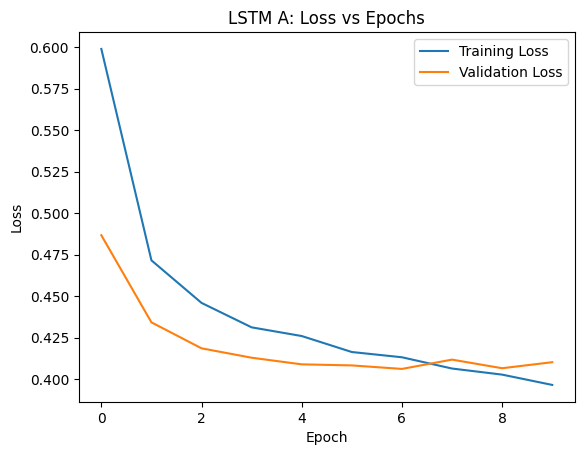

In [24]:
# Plot loss
plt.plot(hist_lstm_a.history['loss'], label='Training Loss')
plt.plot(hist_lstm_a.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSTM A: Loss vs Epochs')
plt.legend()
plt.show()

### Looks pretty good! Our best ROC-AUC value is 0.8925 and it doesn't look like we overfit. I will now keep the hyperparameters the same but change architecture to GRU to compare.

In [25]:
# gru model

# initialize the model
model_gru_a = Sequential()

# add the embedding layer
model_gru_a.add(layers.Embedding(
    input_dim = 14849                # number of tokens from tweets
    , output_dim = 100               # length of vectors in our embedding
    , weights = [embedding_matrix]   # our embedding matrix
    , trainable = False              # we don't want to train the embedding
    )
)

# rnn layer (lstm)
model_gru_a.add(layers.GRU(128))

# add a dense layer with prelu
model_gru_a.add(layers.Dense(32))
model_gru_a.add(layers.PReLU())

# output layer with sigmoid for binary classification
model_gru_a.add(layers.Dense(1, activation='sigmoid'))

# compile
model_gru_a.compile(
    loss = 'binary_crossentropy'
    , optimizer = Adam(learning_rate = 1e-4)
    , metrics = ['auc']
  )

# enable early stopping
early_stopping = EarlyStopping(
    monitor = 'val_loss'
    , patience = 3
    , restore_best_weights = True
)

# train the model
# store it in a variable so we can do plots later
# and fit the best one to the test set
hist_gru_a = model_gru_a.fit(
    x = X_train
    , y = y_train
    , epochs = 20
    , batch_size = 32
    , validation_split = 0.2
    , callbacks = [early_stopping]
)


Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - auc: 0.6467 - loss: 0.6476 - val_auc: 0.7875 - val_loss: 0.5709
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - auc: 0.8099 - loss: 0.5266 - val_auc: 0.8647 - val_loss: 0.4581
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - auc: 0.8526 - loss: 0.4635 - val_auc: 0.8734 - val_loss: 0.4448
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - auc: 0.8624 - loss: 0.4466 - val_auc: 0.8790 - val_loss: 0.4328
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - auc: 0.8599 - loss: 0.4475 - val_auc: 0.8853 - val_loss: 0.4303
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - auc: 0.8781 - loss: 0.4194 - val_auc: 0.8859 - val_loss: 0.4219
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - auc: 0.8813 - loss: 0.4136 - val_auc: 0.8869 - val_loss: 0.4315
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - auc: 0.8802 - loss: 0.4103 - val_auc: 0.8888 - val_loss: 0.4166
Epoch 9/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - au

In [26]:
model_gru_a.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 50, 100)        │     1,484,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 128)            │        88,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_3 (PReLU)               │ (None, 32)             │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,762,441 (6.72 MB)

 Trainable params: 92,513 (361.38 KB)

 Non-trainable params: 1,484,900 (5.66 MB)

 Optimizer params: 185,028 (722.77 KB)

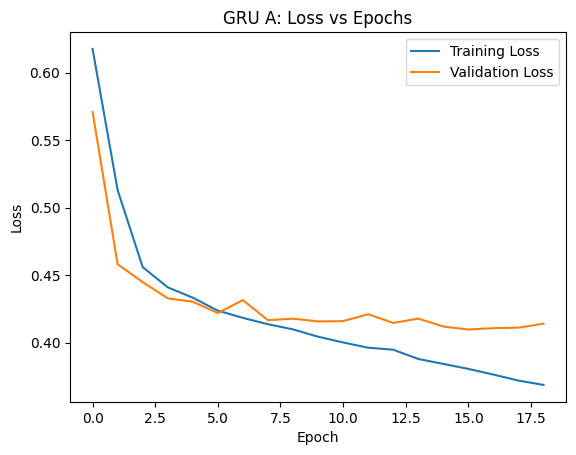

In [28]:
# Plot loss
plt.plot(hist_gru_a.history['loss'], label='Training Loss')
plt.plot(hist_gru_a.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GRU A: Loss vs Epochs')
plt.legend()
plt.show()

### The GRU also does pretty well. However, it took a bit longer to converge and the best ROC-AUC and Loss values were better (by a very small amount though!)
I will move forward with fine tuning the hyperparameters of the LSTM model.

### Model B I will increase the recursive layer and decrease the learning rate

In [30]:
# LSTM Model B

# initialize the model
model_lstm_b = Sequential()

# add the embedding layer
model_lstm_b.add(layers.Embedding(
    input_dim = 14849                # number of tokens from tweets
    , output_dim = 100               # length of vectors in our embedding
    , weights = [embedding_matrix]   # our embedding matrix
    , trainable = False              # we don't want to train the embedding
    )
)

# rnn layer (lstm)
model_lstm_b.add(layers.LSTM(256))   # changed from 128 to 256

# add a dense layer with prelu
model_lstm_b.add(layers.Dense(32))
model_lstm_b.add(layers.PReLU())

# output layer with sigmoid for binary classification
model_lstm_b.add(layers.Dense(1, activation='sigmoid'))

# compile
model_lstm_b.compile(
    loss = 'binary_crossentropy'
    , optimizer = Adam(learning_rate = 5e-5)   # changed from 1e-4 to 5e-5
    , metrics = ['auc']
  )

# enable early stopping
early_stopping = EarlyStopping(
    monitor = 'val_loss'
    , patience = 3
    , restore_best_weights = True
)

# train the model
# store it in a variable so we can do plots later
# and fit the best one to the test set
hist_lstm_b = model_lstm_b.fit(
    x = X_train
    , y = y_train
    , epochs = 20
    , batch_size = 32
    , validation_split = 0.2
    , callbacks = [early_stopping]
)

model_lstm_b.summary()


Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - auc: 0.7108 - loss: 0.6267 - val_auc: 0.8483 - val_loss: 0.4850
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - auc: 0.8534 - loss: 0.4638 - val_auc: 0.8806 - val_loss: 0.4386
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - auc: 0.8712 - loss: 0.4404 - val_auc: 0.8820 - val_loss: 0.4261
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - auc: 0.8733 - loss: 0.4317 - val_auc: 0.8874 - val_loss: 0.4156
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - auc: 0.8794 - loss: 0.4248 - val_auc: 0.8888 - val_loss: 0.4122
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - auc: 0.8752 - loss: 0.4278 - val_auc: 0.8899 - val_loss: 0.4111
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - auc: 0.8759 - loss: 0.4262 - val_auc: 0.8918 - val_loss: 0.4134
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - auc: 0.8793 - loss: 0.4238 - val_auc: 0.8920 - val_loss: 0.4052
Epoch 9/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - au

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 50, 100)        │     1,484,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 256)            │       365,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_5 (PReLU)               │ (None, 32)             │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,606,473 (9.94 MB)

 Trainable params: 373,857 (1.43 MB)

 Non-trainable params: 1,484,900 (5.66 MB)

 Optimizer params: 747,716 (2.85 MB)

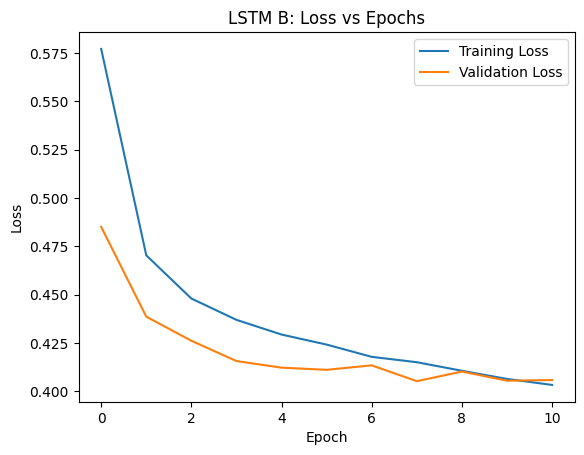

In [31]:
# Plot loss
plt.plot(hist_lstm_b.history['loss'], label='Training Loss')
plt.plot(hist_lstm_b.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSTM B: Loss vs Epochs')
plt.legend()
plt.show()

### For Model C let's increase the depth of the dense layer

In [32]:
# LSTM Model C

# initialize the model
model_lstm_c = Sequential()

# add the embedding layer
model_lstm_c.add(layers.Embedding(
    input_dim = 14849                # number of tokens from tweets
    , output_dim = 100               # length of vectors in our embedding
    , weights = [embedding_matrix]   # our embedding matrix
    , trainable = False              # we don't want to train the embedding
    )
)

# rnn layer (lstm)
model_lstm_c.add(layers.LSTM(256))   # changed from 128 to 256

# add a dense layer with prelu
model_lstm_c.add(layers.Dense(64))
model_lstm_c.add(layers.PReLU())

# output layer with sigmoid for binary classification
model_lstm_c.add(layers.Dense(1, activation='sigmoid'))

# compile
model_lstm_c.compile(
    loss = 'binary_crossentropy'
    , optimizer = Adam(learning_rate = 5e-5)   # changed from 1e-4 to 5e-5
    , metrics = ['auc']
  )

# enable early stopping
early_stopping = EarlyStopping(
    monitor = 'val_loss'
    , patience = 3
    , restore_best_weights = True
)

# train the model
# store it in a variable so we can do plots later
# and fit the best one to the test set
hist_lstm_c = model_lstm_c.fit(
    x = X_train
    , y = y_train
    , epochs = 20
    , batch_size = 32
    , validation_split = 0.2
    , callbacks = [early_stopping]
)

model_lstm_c.summary()

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - auc: 0.6946 - loss: 0.6416 - val_auc: 0.8522 - val_loss: 0.4773
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - auc: 0.8354 - loss: 0.4861 - val_auc: 0.8749 - val_loss: 0.4367
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - auc: 0.8653 - loss: 0.4431 - val_auc: 0.8846 - val_loss: 0.4271
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - auc: 0.8661 - loss: 0.4421 - val_auc: 0.8862 - val_loss: 0.4162
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - auc: 0.8728 - loss: 0.4286 - val_auc: 0.8880 - val_loss: 0.4129
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - auc: 0.8767 - loss: 0.4177 - val_auc: 0.8835 - val_loss: 0.4440
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - auc: 0.8731 - loss: 0.4289 - val_auc: 0.8888 - val_loss: 0.4151
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - auc: 0.8835 - loss: 0.4051 - val_auc: 0.8890 - val_loss: 0.4090
Epoch 9/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - au

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 50, 100)        │     1,484,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 256)            │       365,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_6 (PReLU)               │ (None, 64)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,631,337 (10.04 MB)

 Trainable params: 382,145 (1.46 MB)

 Non-trainable params: 1,484,900 (5.66 MB)

 Optimizer params: 764,292 (2.92 MB)

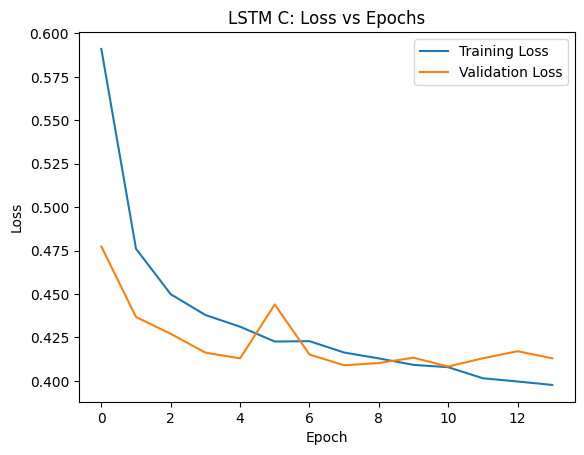

In [33]:
# Plot loss
plt.plot(hist_lstm_c.history['loss'], label='Training Loss')
plt.plot(hist_lstm_c.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSTM C: Loss vs Epochs')
plt.legend()
plt.show()

### For model D I will revert back to the dense layer being 32. I will also further decrease the learning rate and decrease the batch size.

In [35]:
# LSTM Model D

# initialize the model
model_lstm_d = Sequential()

# add the embedding layer
model_lstm_d.add(layers.Embedding(
    input_dim = 14849                # number of tokens from tweets
    , output_dim = 100               # length of vectors in our embedding
    , weights = [embedding_matrix]   # our embedding matrix
    , trainable = False              # we don't want to train the embedding
    )
)

# rnn layer (lstm)
model_lstm_d.add(layers.LSTM(256))

# add a dense layer with prelu
model_lstm_d.add(layers.Dense(32))
model_lstm_d.add(layers.PReLU())

# output layer with sigmoid for binary classification
model_lstm_d.add(layers.Dense(1, activation='sigmoid'))

# compile
model_lstm_d.compile(
    loss = 'binary_crossentropy'
    , optimizer = Adam(learning_rate = 1e-5)   # changed from 1e-4 to 5e-5
    , metrics = ['auc']
  )

# enable early stopping
early_stopping = EarlyStopping(
    monitor = 'val_loss'
    , patience = 3
    , restore_best_weights = True
)

# train the model
# store it in a variable so we can do plots later
# and fit the best one to the test set
hist_lstm_d = model_lstm_d.fit(
    x = X_train
    , y = y_train
    , epochs = 40              # needed to increase because first try didn't converge before limit
    , batch_size = 16          # decreased from 32 to 16
    , validation_split = 0.2
    , callbacks = [early_stopping]
)

model_lstm_d.summary()

Epoch 1/40
381/381 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - auc: 0.6462 - loss: 0.6659 - val_auc: 0.7854 - val_loss: 0.6103
Epoch 2/40
381/381 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - auc: 0.7733 - loss: 0.5946 - val_auc: 0.8353 - val_loss: 0.5263
Epoch 3/40
381/381 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - auc: 0.8200 - loss: 0.5240 - val_auc: 0.8523 - val_loss: 0.4809
Epoch 4/40
381/381 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - auc: 0.8395 - loss: 0.4871 - val_auc: 0.8636 - val_loss: 0.4615
Epoch 5/40
381/381 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - auc: 0.8407 - loss: 0.4836 - val_auc: 0.8699 - val_loss: 0.4500
Epoch 6/40
381/381 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - auc: 0.8512 - loss: 0.4659 - val_auc: 0.8752 - val_loss: 0.4402
Epoch 7/40
381/381 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - auc: 0.8563 - loss: 0.4583 - val_auc: 0.8772 - val_loss: 0.4355
Epoch 8/40
381/381 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - auc: 0.8587 - loss: 0.4537 - val_auc: 0.8809 - val_loss: 0.4292
Epoch 9/40
381/381 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - au

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ (None, 50, 100)        │     1,484,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 256)            │       365,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_8 (PReLU)               │ (None, 32)             │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,606,473 (9.94 MB)

 Trainable params: 373,857 (1.43 MB)

 Non-trainable params: 1,484,900 (5.66 MB)

 Optimizer params: 747,716 (2.85 MB)

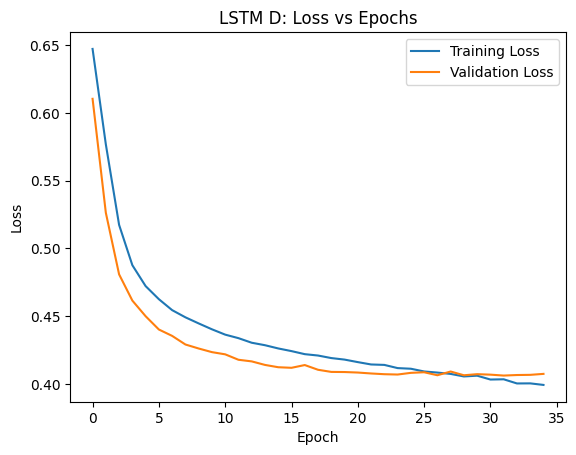

In [37]:
# Plot loss
plt.plot(hist_lstm_d.history['loss'], label='Training Loss')
plt.plot(hist_lstm_d.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSTM D: Loss vs Epochs')
plt.legend()
plt.show()

### I think that's about as good as we're going to do on this architecture.

## Results and Analysis
The LSTM model outperformed the GRU model with our initial set of hyperparameters. I then tested several hyperparameter configurations and architecture adjustments to tune the LSTM Model. Here are the results:  
  
| Model         | Best Validation ROC-AUC | Best Validation Loss |
|---------------|--------------|-----------|
| GRU Model A   | 0.8926       | 0.4097    |
| LSTM Model A  | 0.8925       | 0.4062    |
| LSTM Model B  | 0.8921       | 0.4052    |
| LSTM Model C  | 0.8908       | 0.4082    |
| LSTM Model D  | 0.8922       | 0.4062    |

  
The last model tested, maybe not surprisingly, achieved the best results. This model, model D, used 256 LSTM layers, 32 Dense layers using PreLU activation, and a single output layer with sigmoid activation for binary classification. A learning rate of 0.0001 was used with an Adam optimizer.  
  
I think the GRU model and the LSTM models A and B suffered from not being complex enough to capture all the nuance in the embedded vectors. Model C on the other hand may have overfit and not been able to generalize well. Meaning that when we reduced the complexity in model D, but kept low learning rates and batch jobs, we saw the model find a nice mix between complexity and generalization.

238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


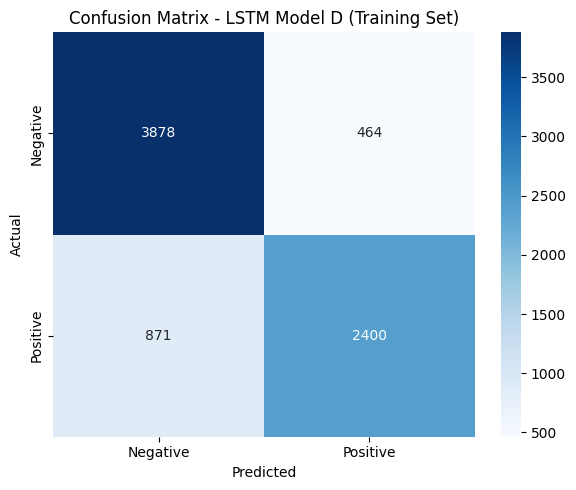

In [55]:
# create a confusion matrix for the model d training set
y_pred = model_lstm_d.predict(X_train)
y_pred = (y_pred >= 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y_train, y_pred)

# Optional: define class labels
labels = ['Negative', 'Positive']  # or ['Class 0', 'Class 1']

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - LSTM Model D (Training Set)')
plt.tight_layout()
plt.show()


In [54]:
# make predictions with model d for the test values
y_pred = model_lstm_d.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)

# combine y_pred with the test labels
output = pd.DataFrame({
    'id': test['id']
    , 'target': y_pred.flatten()
    })


output

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [56]:
# output to csv for submission
output.to_csv('submission.csv', index = False)

# download the csv
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Conclusion
Remember that the point of this project was to detect what tweets represented actual dangerous conditions. While we can't see the actual values for the test set, we can see the F1 score. My F1 Score on the test set is 0.80661.
  
However, this only gives us so much information. In a setting like this we want to minimize as many false negatives as possible. It's kind of like a reverse 'Boy Who Cries Wolf' situation. We want to believe all of the tweets that actually are about dangerous conditions. This means we should optimize for sensitivity. To do that, we try and eliminate as many false negatives as possible.  
  
If I had more time to work on this project, I would attempt more architectures and hyperparameter configuarations to find the model that maximizes sensitivity, not maximize the F1 score like in the contest.
  
The biggest thing I learned in this lab is that vector embeddings can be complex. I'm trankful I found the resouces below to help me with implementing the code. Another challenge is the cleaning. Tweets are a very unique subset of language and a lot more work could be done to clean up what we have in that dataset.

## References
Zhu, S., & Chollet, F. (2023, November 16). Working with RNNs. TensorFlow.
  
  
https://www.tensorflow.org/guide/keras/working_with_rnns    
  
**Glove guides**  
Theiler, S. (2019, September 7). Basics of using pre-trained GloVe vectors in Python. Medium.  
https://medium.com/analytics-vidhya/basics-of-using-pre-trained-glove-vectors-in-python-d38905f356db


Pennington, J., Socher, R., & Manning, C. D. (n.d.). GloVe: Global Vectors for Word Representation. Stanford NLP Group.  https://nlp.stanford.edu/projects/glove/
  
**Keras Documentation**  
https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization  
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer  
https://keras.io/api/layers/core_layers/embedding/